In [1]:
import sys
sys.path.append('../modules')

import utils
from RateEchoStateNet import RateEchoStateNet as RateNet

import numpy as np
from numba import njit, prange
import matplotlib
import matplotlib.pyplot as plt

import scipy.integrate

# Generate data from Lorenz attractor

In [2]:
xyz0 = np.random.rand(3)
sigma = 10
rho = 28
beta = 8/3

start = 0
end = 300
Time = np.linspace(start, end, int(2e5))

solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = xyz0, args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True)
solver = scipy.integrate.solve_ivp(utils.lorenz_derivative, t_span = [start, end], y0 = solver.sol(end), args=(sigma, rho, beta),
                                   t_eval = Time, dense_output = True, method = 'DOP853')
xyz = solver.sol(Time).T

xyz -= xyz.min(axis = 0)
xyz /= xyz.max(axis = 0)

xyz = np.ascontiguousarray(xyz[::2])
Time = Time[::2]

print(xyz.shape)

(100000, 3)


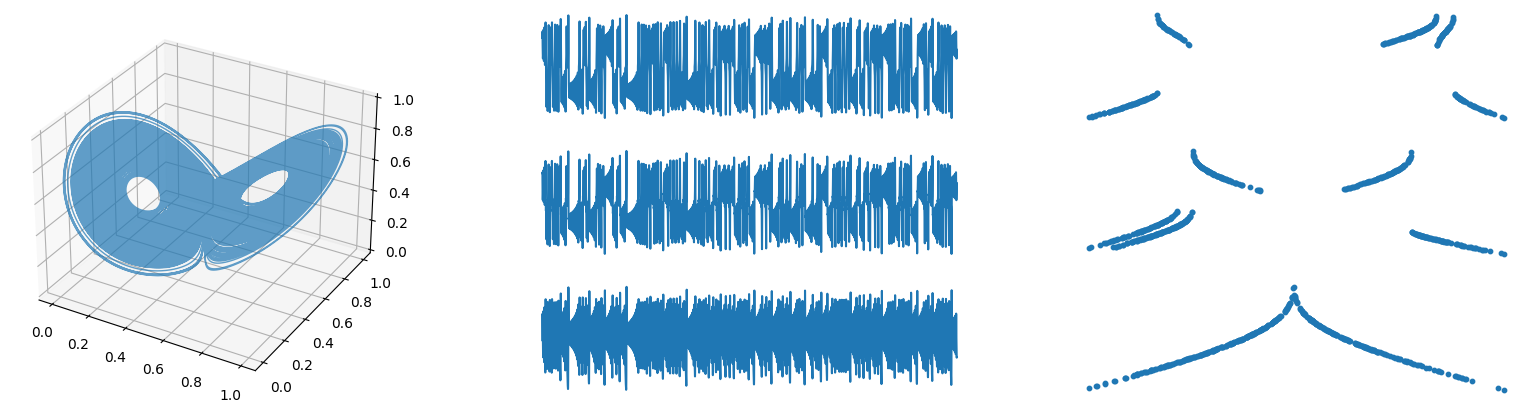

In [3]:
fig = plt.figure(figsize = (20,5))
axs = fig.subplot_mosaic('A03;A14;A25')
ss = axs['A'].get_subplotspec()
axs['A'].remove()
axs['A'] = fig.add_subplot(ss, projection='3d')
axs['A'].plot(*xyz.T, alpha=0.7, linewidth=1)

for i in range(3):
    axs[str(i)].plot(Time, xyz[:,i])
    axs[str(i)].axis('off')
    axs[str(i + 3)].scatter(*utils.return_map(xyz[:,i]), s = 10)
    axs[str(i + 3)].axis('off')
plt.show()

# Echo State Network

In [4]:
def run_nonlinearity(net, initTraining, idx_start, idx_echo, nLoops,
                     alpha_min = 1e-8, alpha_max = 1e-1, NAlpha = 30):
    net.fit_alpha(xyz, initTraining, idx_start, idx_echo, nLoops,
                  alpha_min = alpha_min, alpha_max = alpha_max, NAlpha = NAlpha)
    print("Best alpha: ", net.alpha)
    print("Best MSE: ", net.MSE_echo)

    E_echo, I_echo, output_echo = net.echo_state(xyz, nLoops, idx_start = idx_start,
                                                 idx_echo = idx_echo, plot = True)
    
    net.plot_attractor(output_echo[idx_echo:])

    _ = net.compare_results(xyz, output_echo[idx_echo:], NBins = 100)

    return net

In [5]:
N = 50
NE = int(0.8*N)
NI = int(0.2*N)
NInputs = 3

input_sparse = 0.3

dt = 0.05

tau_E = 1.
tau_I = 1.

np.random.seed(42)

Win = np.random.randn(NInputs, NE)
Win[Win < input_sparse] = 0

WEE = np.random.rand(NE, NE)
WEE[np.diag_indices(NE)] = 0

WII = np.random.rand(NI, NI)
WII[np.diag_indices(NI)] = 0

WIE = np.random.rand(NI, NE)
WEI = np.random.rand(NE, NI)

for W in [WIE, WII]:
            W /= np.sum(W, axis = 1)[..., None]
            
for W in [WEI, WEE]:
    W /= (np.sum(W, axis = 1) + Win.sum(axis = 0))[..., None]

In [6]:
initTraining = 100
idx_start = 5000
idx_echo = 1000
nLoops = 10000

## ReLU activation function

In [39]:
net_ReLU = RateNet(NE, NI, NInputs, dt, tau_E, tau_I, burnSteps = None,
                   input_sparse = input_sparse, max_bias = None,
                   method = 'rk4', nonlinearity = utils.ReLU, args_nonlin = ())

net_ReLU._set_network(WEE, WII, WEI, WIE, Win)

New MSE: 69.03914 for alpha = 1e-08
New MSE: 68.01159 for alpha = 0.006896561034482759
New MSE: 63.38847 for alpha = 0.013793112068965519
New MSE: 59.81758 for alpha = 0.0172413875862069
New MSE: 58.22503 for alpha = 0.02068966310344828
New MSE: 56.41254 for alpha = 0.02413793862068966
New MSE: 55.23679 for alpha = 0.02758621413793104
New MSE: 53.43706 for alpha = 0.031034489655172418
New MSE: 50.67501 for alpha = 0.0344827651724138
New MSE: 48.99857 for alpha = 0.03793104068965518
New MSE: 47.95929 for alpha = 0.04137931620689656
New MSE: 46.47682 for alpha = 0.04482759172413794
New MSE: 45.53727 for alpha = 0.04827586724137932
New MSE: 43.5857 for alpha = 0.051724142758620695
New MSE: 42.2074 for alpha = 0.05517241827586208
New MSE: 41.29935 for alpha = 0.05862069379310346
New MSE: 40.35037 for alpha = 0.062068969310344835
New MSE: 39.45786 for alpha = 0.06551724482758621
New MSE: 38.91962 for alpha = 0.06896552034482759
New MSE: 37.96826 for alpha = 0.07241379586206897
New MSE: 36.9

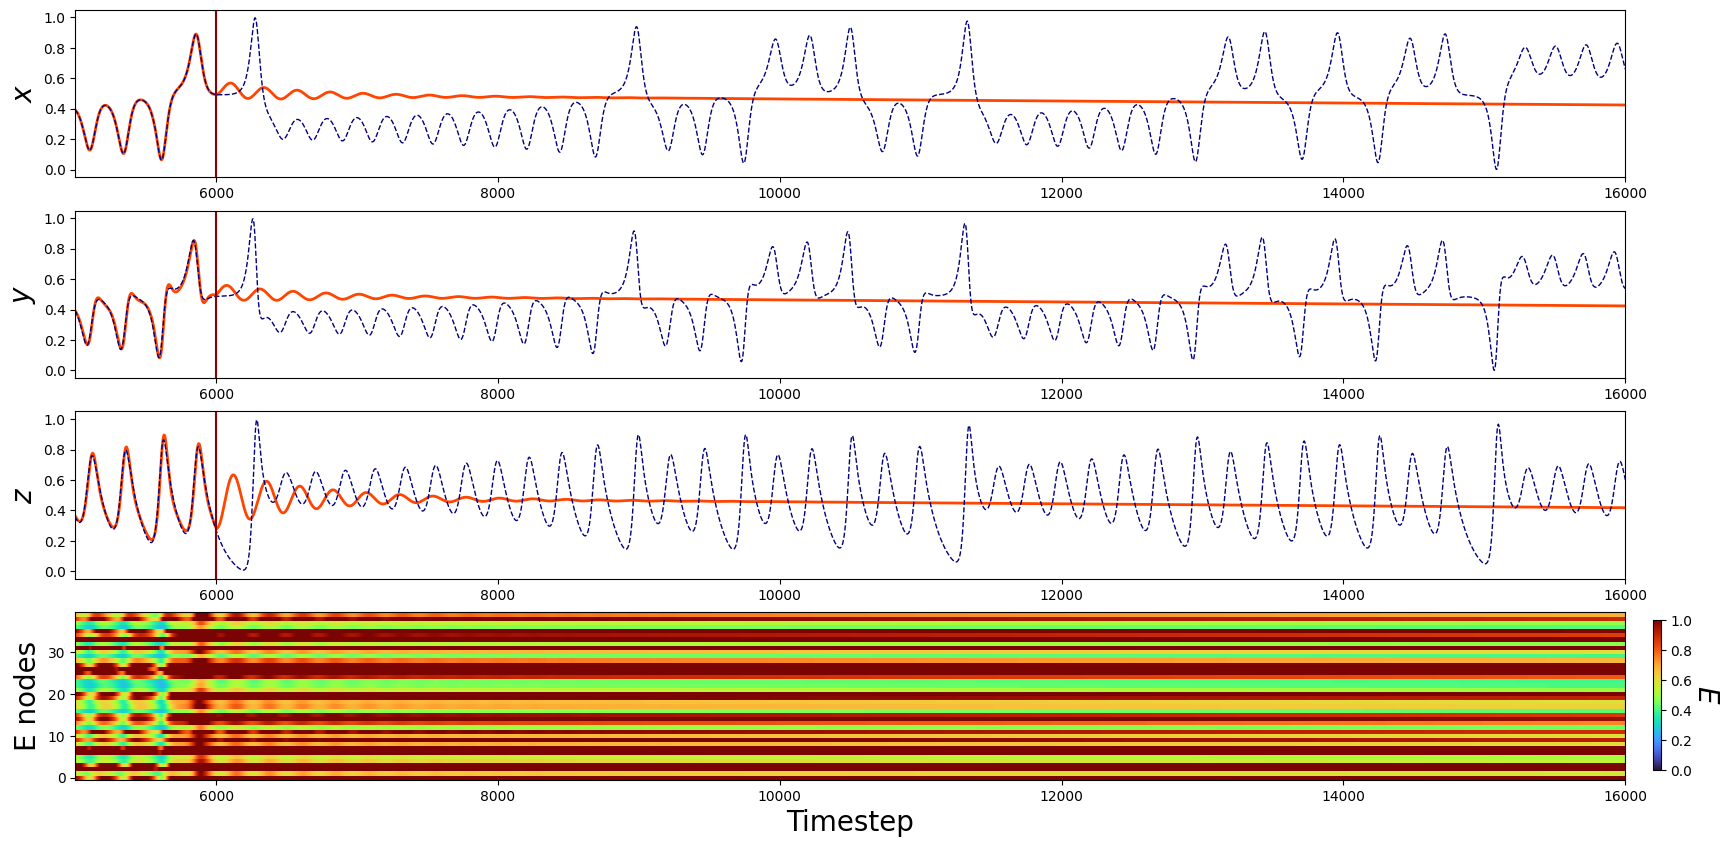

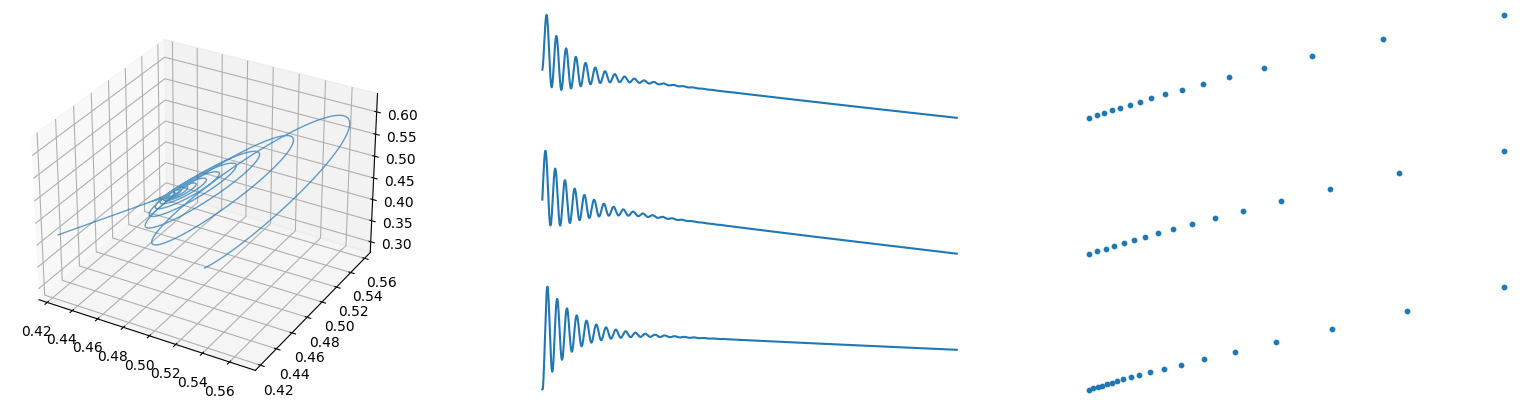

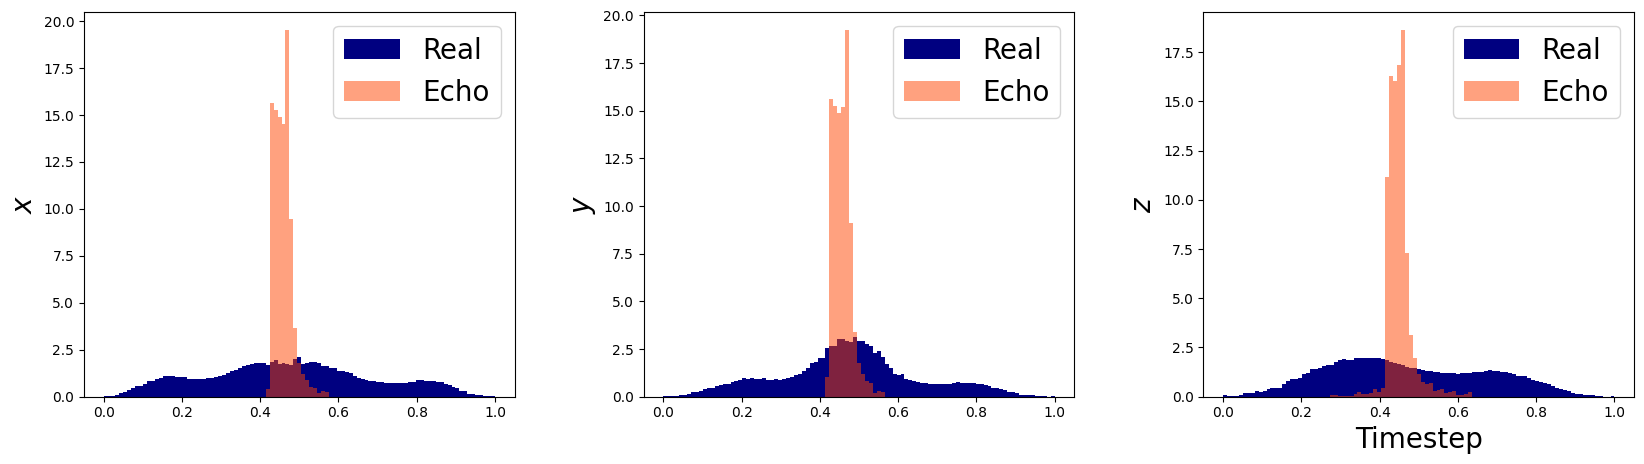

In [40]:
net_ReLU = run_nonlinearity(net_ReLU, initTraining, idx_start, idx_echo, nLoops)

## Sigmoid activation function

In [10]:
net_sigm = RateNet(NE, NI, NInputs, dt, tau_E, tau_I, burnSteps = None,
                   input_sparse = input_sparse, max_bias = None,
                   method = 'rk4', nonlinearity = utils.sigmoid, args_nonlin = ())

net_sigm._set_network(WEE, WII, WEI, WIE, Win)

New MSE: 2.56506 for alpha = 1e-08
New MSE: 1.70587 for alpha = 0.04137931620689656
Best alpha:  0.04137931620689656
Best MSE:  1.7058725555478575


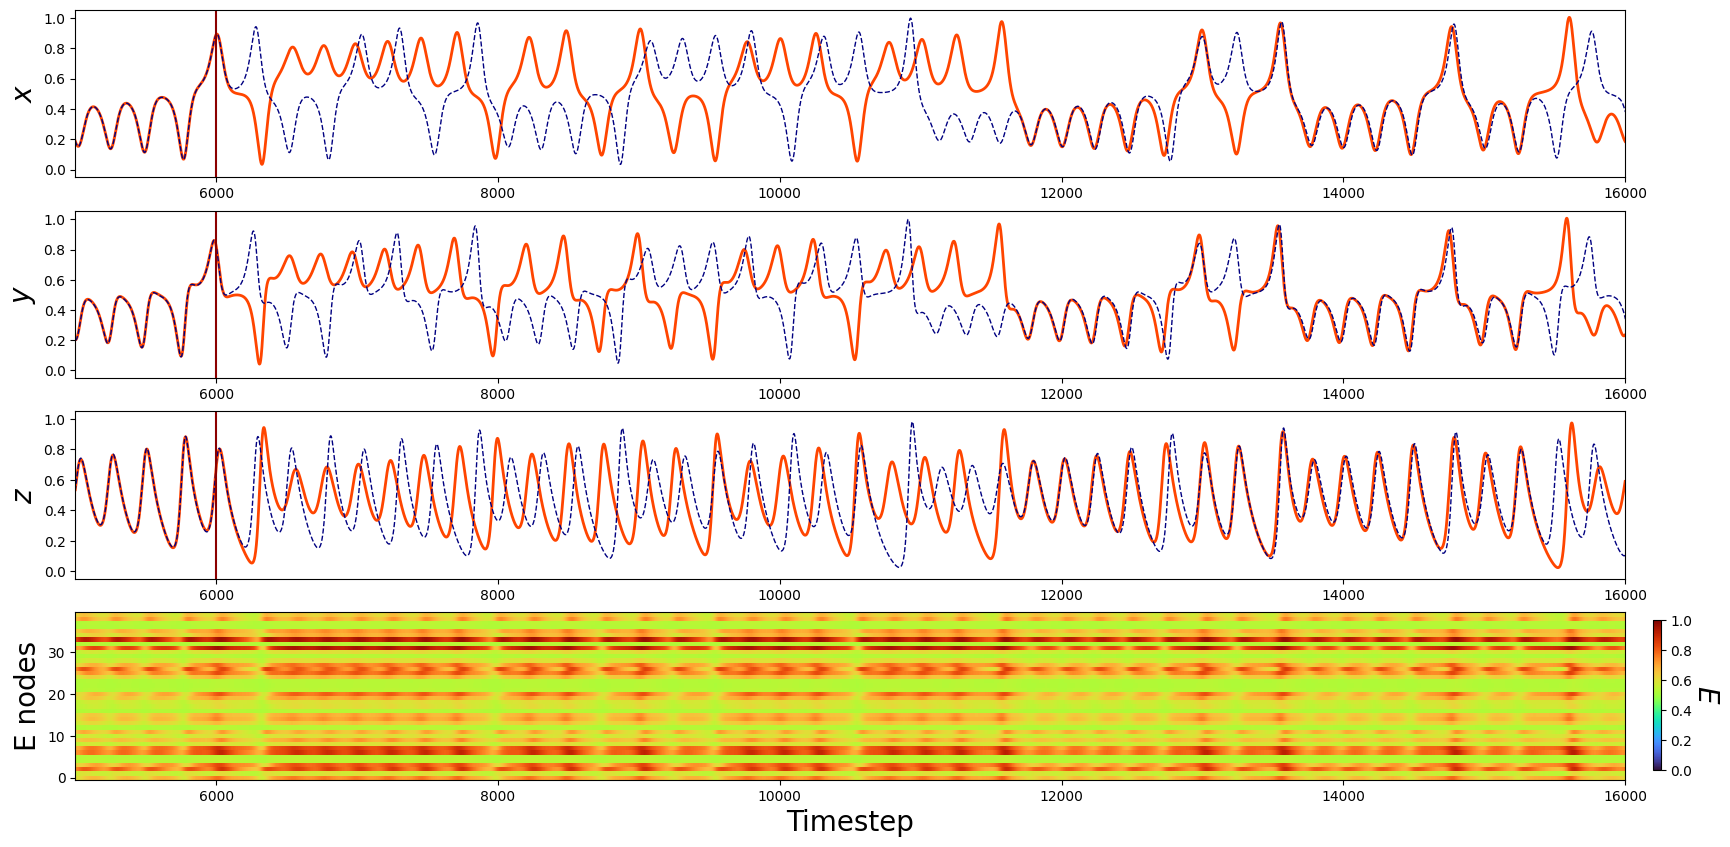

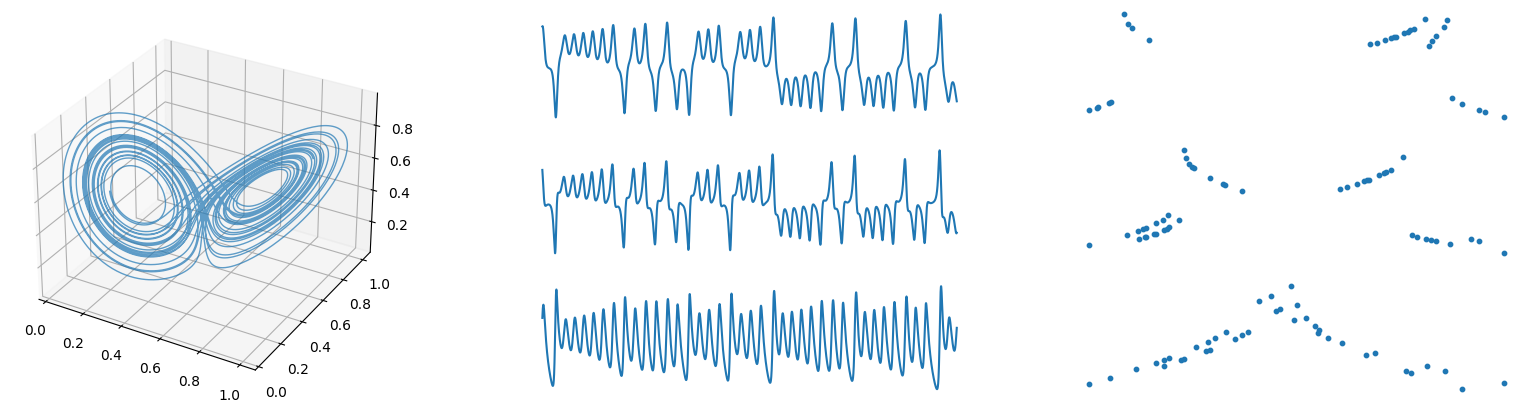

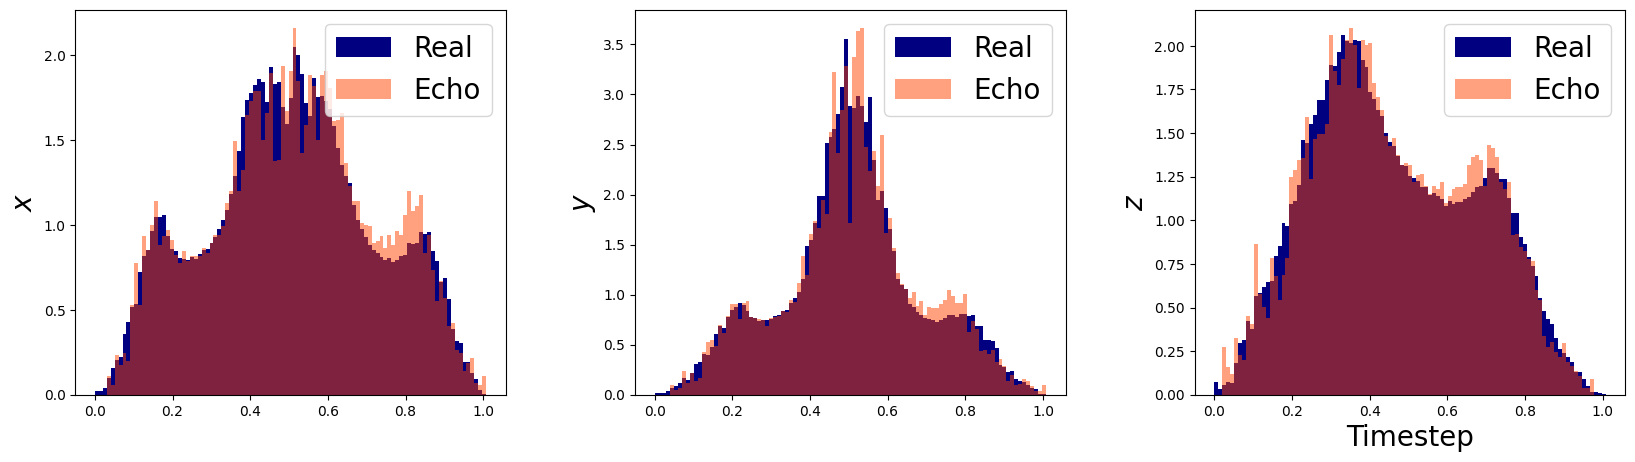

In [11]:
net_sigm = run_nonlinearity(net_sigm, initTraining, idx_start, idx_echo, nLoops)

## Corrected ReLU activation function

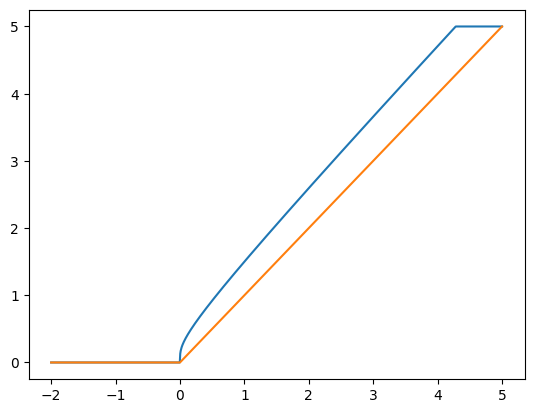

In [32]:
xx = np.linspace(-2,5,1000)
plt.plot(xx, utils.ReLU_Poly(xx, eps = 0.5, sat = 5, exp = 0.25))
plt.plot(xx, utils.ReLU(xx))

In [37]:
net_ReLUP = RateNet(NE, NI, NInputs, dt, tau_E, tau_I, burnSteps = None,
                    input_sparse = input_sparse, max_bias = None,
                    method = 'rk4', nonlinearity = utils.ReLU_Poly,
                    args_nonlin = (0.5, 2.5, 0.25))

net_ReLUP._set_network(WEE, WII, WEI, WIE, Win)

New MSE: 2.99525 for alpha = 1e-08
Best alpha:  1e-08
Best MSE:  2.995246142520432


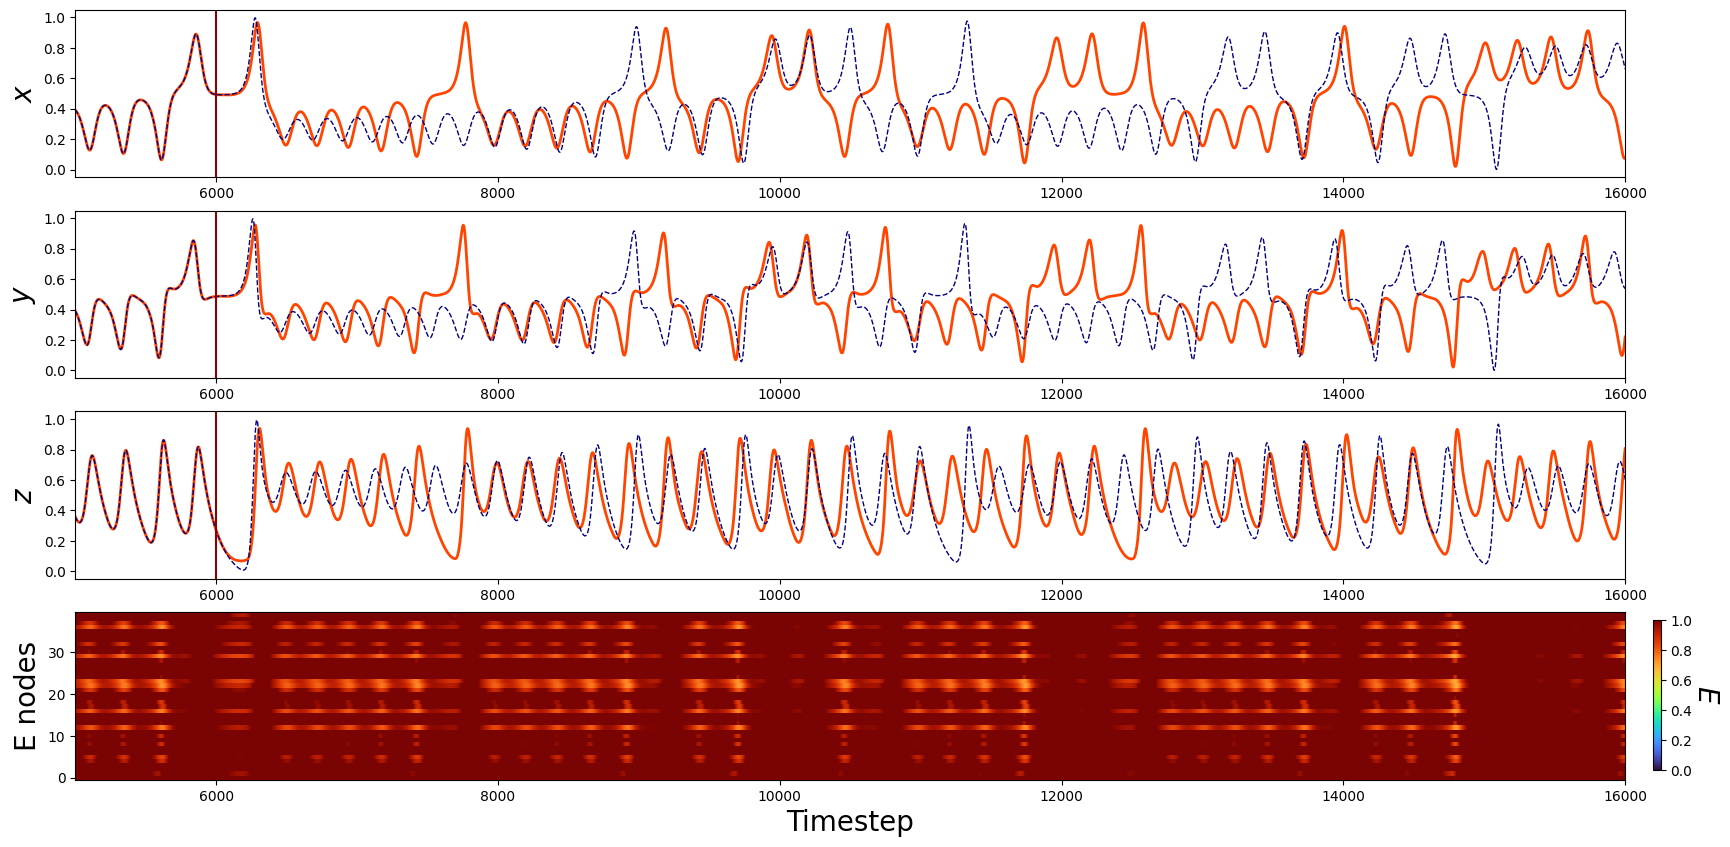

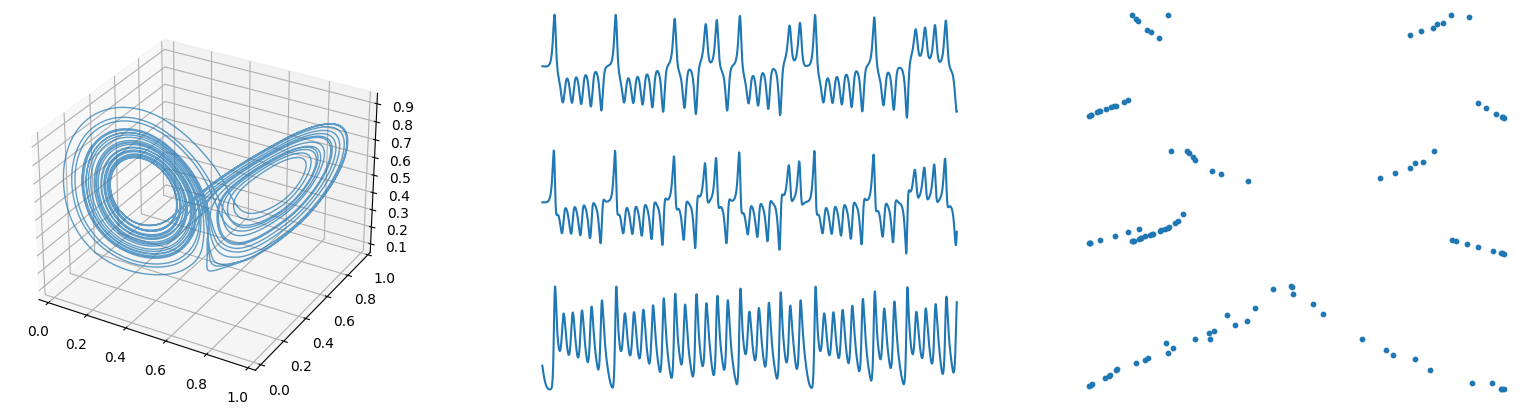

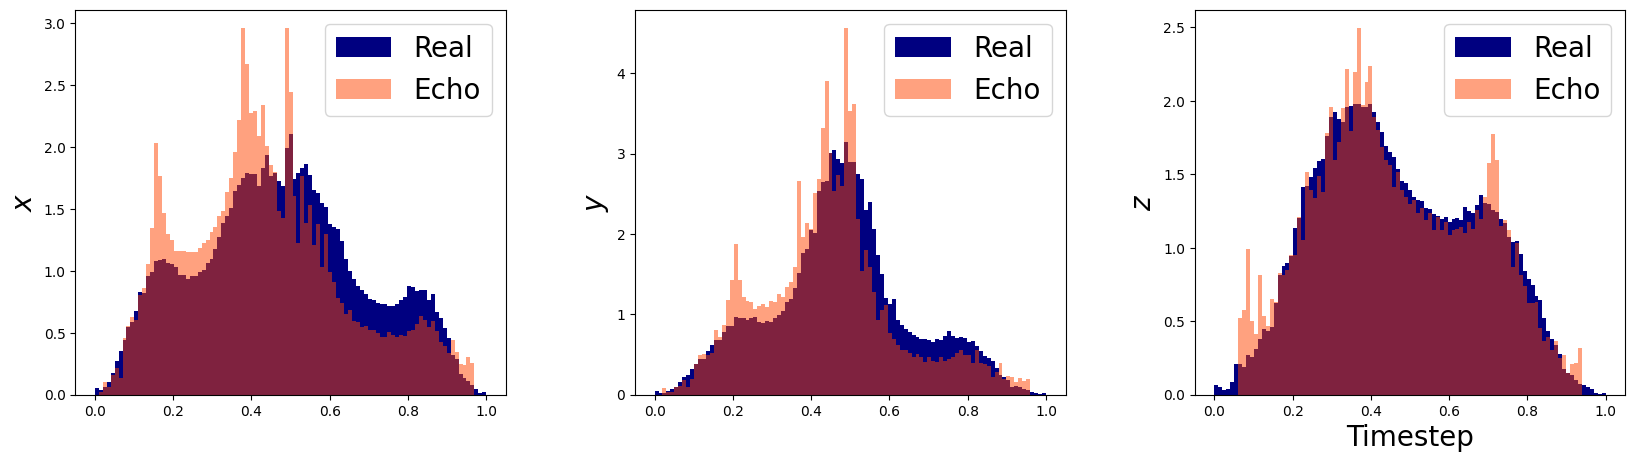

In [38]:
net_ReLUP = run_nonlinearity(net_ReLUP, initTraining, idx_start, idx_echo, nLoops, NAlpha = 10)